# Systèmes dynamiques

![](data/animated-lorenz-attractor.gif)
[source](https://geoffboeing.com/2016/12/animating-lorenz-attractor-python/)

## Méthodes numériques

[Sources méthodes numériques](https://femto-physique.fr/analyse-numerique/runge-kutta.php)

## résolution brute ..

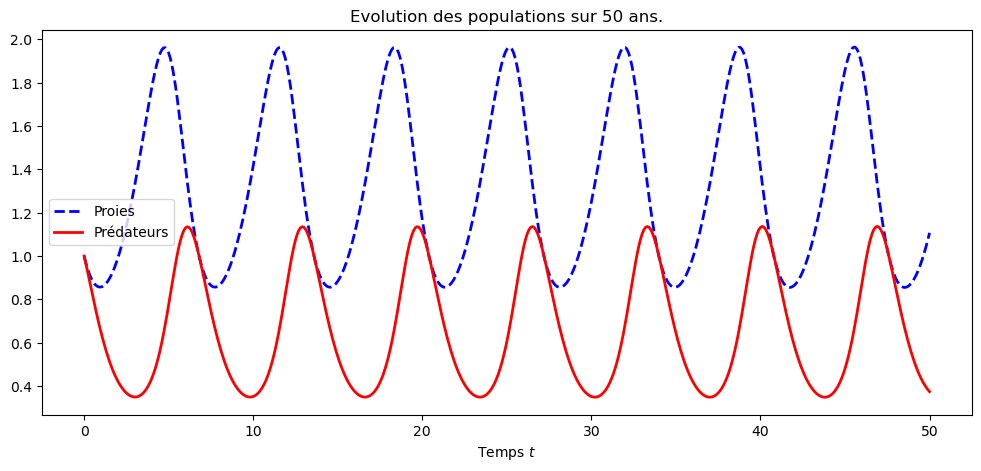

In [1]:
import matplotlib.pyplot as plt
import numpy as np

a, b, c = 2/3, 4/3, 1
def LV(t,X):
    x, y = X
    fx = a*x - c*x*y
    fy = -b*y + c*x*y
    fX = np.array([fx, fy])
    return fX

def euler(t,X,dt, f):
    return X + dt*f(t,X)

def RK2(t,X,dt, f):
    k1 = f(t,X)
    k2 = f(t+dt, X+dt*k1)
    newX = X + dt*(1/2*k1+1/2*k2)
    return newX

def RK4(t,X,dt, f):
    ...
    
    return ...

x0, y0 = 1, 1
X = np.array([x0,y0])
hist_X = [X]

t0=0
tf = 50
dt = 0.1
t = t0
hist_t = [t]


while t <= tf:
    X = RK2(t,X,dt, LV)
    t += dt
    hist_X.append(X)
    hist_t.append(t)

hist_X = np.array(hist_X)

# figure :
plt.figure(figsize=(12,5))
plt.title(f"Evolution des populations sur {tf} ans.")
plt.plot(hist_t, hist_X[:,0],c='b',label='Proies',linewidth=2,linestyle='--');
plt.plot(hist_t, hist_X[:,1],c='r',label='Prédateurs',linewidth=2);
plt.xlabel(r'Temps $t$'); plt.legend();

## Avec une classe model générique ...

In [2]:
import matplotlib.pyplot as plt
import numpy as np

class Model:
    def __init__(self, trend_parameters = None, scheme_name ='explicit_euler'):
        self.trend_parameters = trend_parameters
        self.trend = self._make_trend()
        self.scheme_name = scheme_name
        self.available_schemes = ['explicit_euler','RK2','RK4']
        self.scheme = self._make_scheme()
    
    def _make_trend(self):
        return None
    
    def _make_scheme(self):
        if not self.scheme_name in self.available_schemes :
            raise ValueError(f"Le schéma temporel '{self.scheme_name}' n'est pas disponible.\nListe des schémas disponibles: {self.available_schemes}")
        
        def explicit_euler(f,x,t,dt):
            return x + dt*f(t,x)
            
        def RK2(f,x,t,dt):
            k1 = f(t,x)
            k2 = f(t+dt,x+dt*k1)
            return x + dt*(k1/2 + k2/2)
        
        def RK4(f,x,t,dt):
            k1 = f(t,x)
            k2 = f(t+dt/2, x+dt/2*k1)
            k3 = f(t+dt/2, x+dt/2*k2)
            k4 = f(t+dt, x+dt*k3)
            return x + dt/6 *(k1+2*k2+2*k3+k4)
            
            
        if self.scheme_name == 'explicit_euler': return explicit_euler
        elif self.scheme_name == 'RK2': return RK2
        else : return RK4
            
    def time_window(self, t_end, dt, t0=0,sub_div_saved_times=1):
        times = list(np.arange(t0, t_end,dt))
        if not t_end in times : times += [t_end]
        saved_times  = times[::sub_div_saved_times]
        if not t_end in saved_times : saved_times += [t_end]
        return times, saved_times

    def forecast(self, x0, times, saved_times = None):
        saved_times = times if saved_times is None else saved_times
        trajectory = {times[0]:x0}
        x = x0
        for prev_time, time in zip(times[:-1],times[1:]):
            dt = time - prev_time
            x = self.scheme(self.trend, x, time, dt)
            
            if time in saved_times: trajectory[time] = x
        
        return trajectory

## Lotka-Volterra

In [3]:
class LotkaVolterra(Model):
    def __init__(self, trend_parameters={"a":0.66,'b':1.33,"c":1},scheme_name ='explicit_euler'):
        super().__init__(trend_parameters, scheme_name)
        self.trend = self._make_trend()
    
    def _make_trend(self):
        def trend(t,X):
            x, y = X
            fx =  self.trend_parameters['a']*x - self.trend_parameters['c']*x*y
            fy = -self.trend_parameters['b']*y + self.trend_parameters['c']*x*y
            fX = np.array([fx, fy])
            return fX
        return trend
    
    def plot_traj(self,traj):
        tmax = np.max(np.array(list(traj.keys())))
        hist_X = np.array(list(traj.values()))
        plt.figure(figsize=(10,5))
        tmax
        plt.title(f"Evolution des populations sur {int(tmax)} ans")
        plt.plot(saved_times, hist_X[:,0],c='b',linestyle='--',label='Proie')
        plt.plot(saved_times, hist_X[:,1],c='r',linewidth=2,label='Prédateur');
        plt.xlabel(r"$t$")
        plt.legend();
        

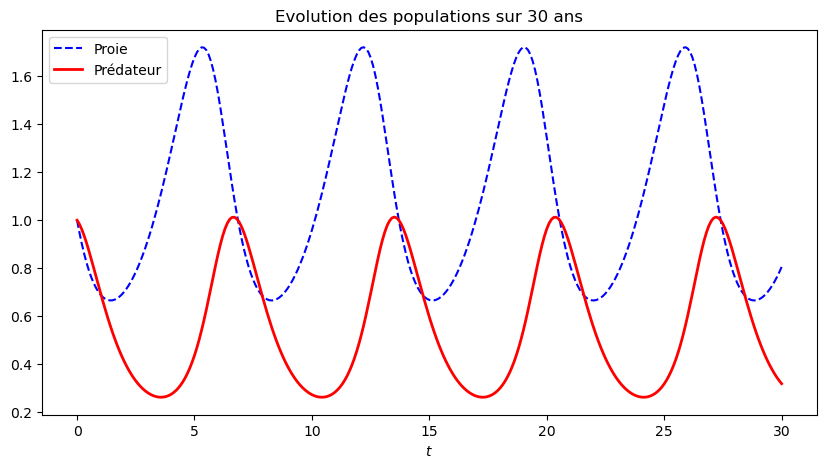

In [4]:
trend_parameters={"a":2/3,'b':4/3,"c":1.2}
lv = LotkaVolterra(trend_parameters=trend_parameters, scheme_name='RK4')

x0 = np.array([1,1])
times, saved_times = lv.time_window(30, 0.1)
traj = lv.forecast(x0, times, saved_times=saved_times)

lv.plot_traj(traj)

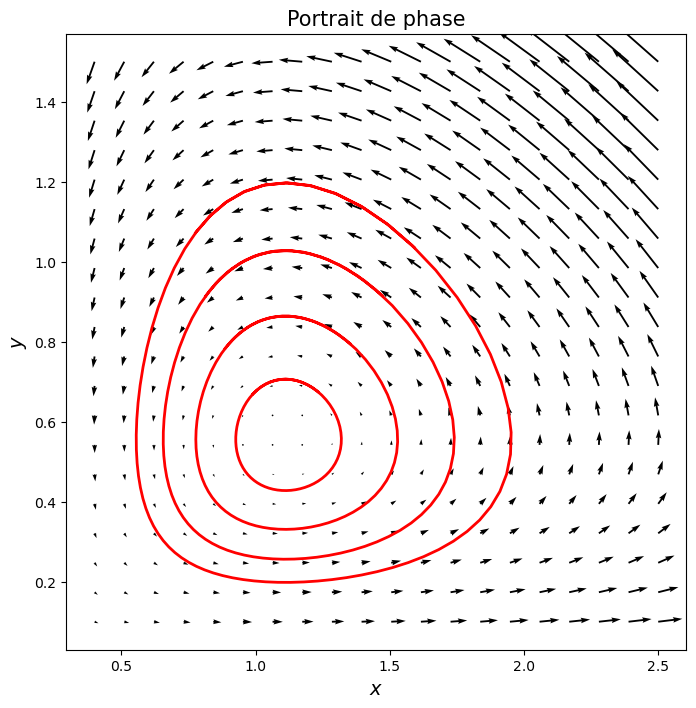

In [5]:
fix_pt = np.array([trend_parameters['b']/trend_parameters['c'], trend_parameters['a']/trend_parameters['c']])

direction = np.array([1.,1.])
step = 0.12

times, saved_times = lv.time_window(8, 0.1)

n_orbits = 4
plt.figure(figsize=(8,8))
plt.title("Portrait de phase",fontsize=15)
for i in range(1,n_orbits+1):
    traj = lv.forecast(fix_pt +i*step, times, saved_times=saved_times)
    hist_X = np.array(list(traj.values()))
    plt.plot(hist_X[:,0],hist_X[:,1], c='r',linewidth=2)

plt.xlabel(r"$x$", fontsize=14) ; plt.ylabel(r"$y$", fontsize=14);

n = 20
X,Y = np.meshgrid(np.linspace(0.4,2.5,n), np.linspace(0.1,1.5,n))

Z = lv.trend(0,[X,Y])

plt.quiver(X, Y, Z[0],Z[1]);

# Comparaison avec différents pas de temps pour Euler explicite

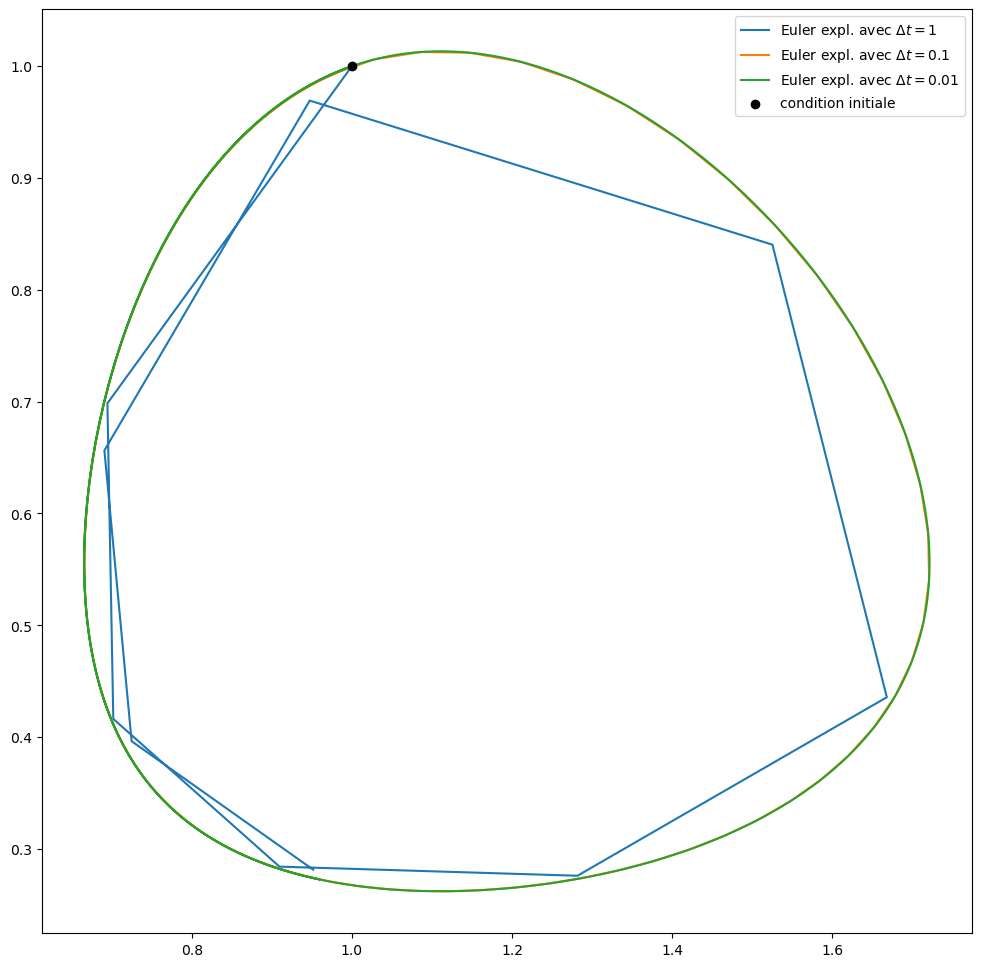

In [6]:
trend_parameters={"a":2/3,'b':4/3,"c":1.2}
lv = LotkaVolterra(trend_parameters=trend_parameters, scheme_name='RK4')

x0 = np.array([1,1])

dts = [1,0.1,0.01]

trajs = {}
plt.figure(figsize=(12,12))
for dt in dts:
    times, saved_times = lv.time_window(10, dt)
    traj = lv.forecast(x0, times, saved_times=saved_times)
    
    traj_X = np.array(list(traj.values()))
    plt.plot(traj_X[:,0], traj_X[:,1],label='Euler expl. avec ' +fr'$\Delta t=${dt}')
    
plt.scatter([1],[1],c='k',zorder=3,label='condition initiale')
plt.legend();

## Comparaison des différents schémas temporels pour un même pas de temps :

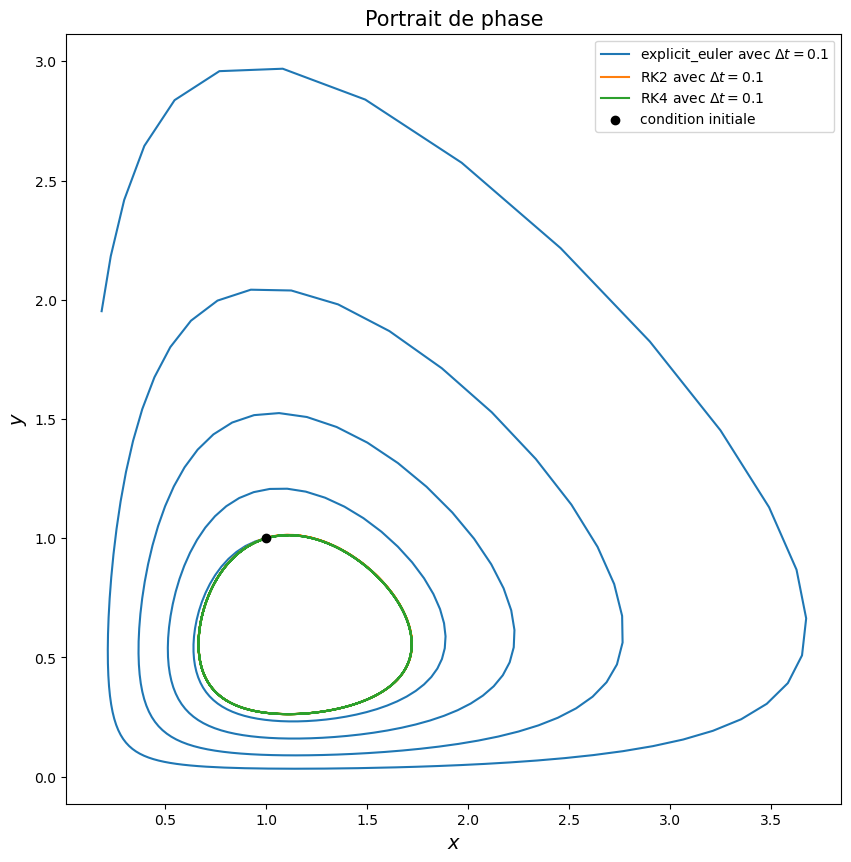

In [7]:
trend_parameters={"a":2/3,'b':4/3,"c":1.2}
schemes = ['explicit_euler', 'RK2', 'RK4']

x0 = np.array([1,1])
dt = 0.1
plt.figure(figsize=(10,10))
for scheme in schemes:
    lv = LotkaVolterra(trend_parameters=trend_parameters,scheme_name=scheme)
    times, saved_times = lv.time_window(30, dt)
    traj = lv.forecast(x0, times, saved_times=saved_times)
    traj_X = np.array(list(traj.values()))
    plt.plot(traj_X[:,0], traj_X[:,1],label=f'{scheme} avec ' +fr'$\Delta t=${dt}')
    
plt.scatter([1],[1],c='k',zorder=3,label='condition initiale')
plt.legend();
plt.title("Portrait de phase",fontsize=15)
plt.xlabel(r"$x$", fontsize=14) ; plt.ylabel(r"$y$", fontsize=14);

## Lorentz

[Source code](https://en.wikipedia.org/wiki/Lorenz_system#Python_simulation)

C:\Users\aperrot\AppData\Local\Temp\ipykernel_15212\4055826603.py:20: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection="3d")


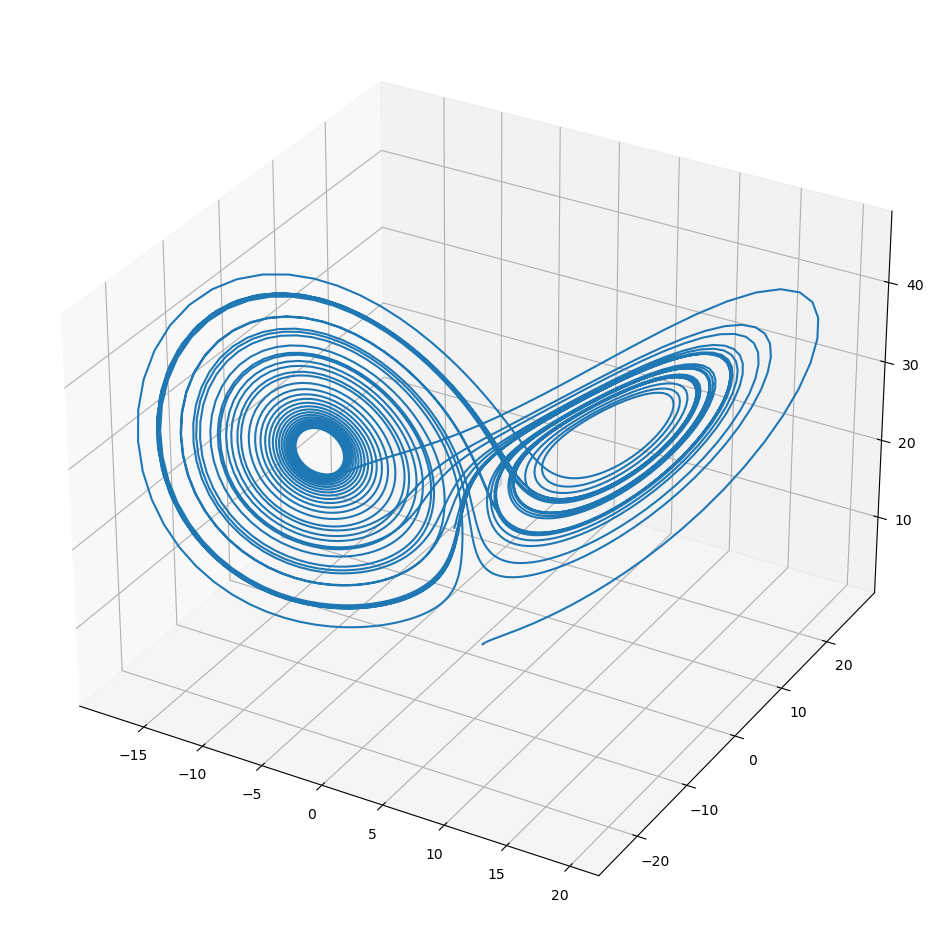

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D

rho = 28.0
sigma = 10.0
beta = 8.0 / 3.0

def f(state, t):
    x, y, z = state  # Unpack the state vector
    return sigma * (y - x), x * (rho - z) - y, x * y - beta * z  # Derivatives

state0 = [1.0, 1.0, 1.0]
t = np.arange(0.0, 40.0, 0.01)

states = odeint(f, state0, t)

fig = plt.figure(figsize=(12,12))
ax = fig.gca(projection="3d")
ax.plot(states[:, 0], states[:, 1], states[:, 2])
plt.draw()
plt.show()

#  Linearizing a non-linear dynamic

### Creating a database

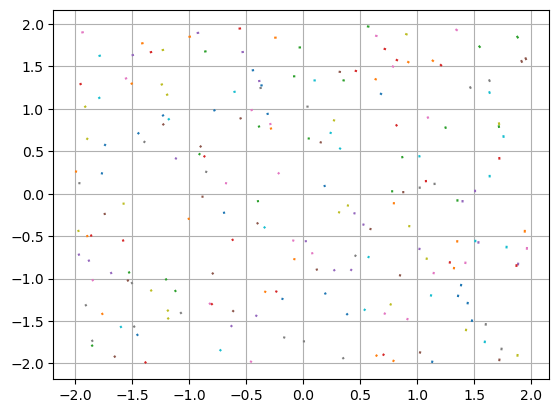

In [106]:
trend_parameters={"a":2/3,'b':4/3,"c":1.2}
fix_pt = np.array([trend_parameters['b']/trend_parameters['c'], trend_parameters['a']/trend_parameters['c']])

x0 = np.array([1,1])
dt = 0.001
scheme = 'RK4'
lv = LotkaVolterra(trend_parameters=trend_parameters, scheme_name=scheme)


# building a database:
N_samples = 10 ** 6

X = []
Y = []

def koopman(x):
    return np.log(x) - np.log(fix_pt)

def koopman_inv(y):
    return fix_pt * np.exp(y)

for i in range(N_samples):
    yy = np.random.uniform(-2, 2, (2,))
    x = koopman_inv(yy) #
    #x = np.random
#     x = np.random.uniform(0,3.5, (2,))
    times, saved_times = lv.time_window(dt, dt)
    traj = lv.forecast(x, times, saved_times=saved_times)
    traj_X = np.log(np.array(list(traj.values()))) - np.log(fix_pt)
#     traj_X = np.array(list(traj.values()))
    if i < 200:
        plt.plot(traj_X[:,0], traj_X[:,1],label=f'{scheme} avec ' +fr'$\Delta t=${dt}')
    x = traj_X[0]
    y = traj_X[-1]
    
    X.append(x)
    Y.append(y)

plt.grid()    
X = np.array(X)
Y = np.array(Y)

### completing mapping operator

In [107]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=8, include_bias=True)


# Transform the data
X_poly = poly.fit_transform(X)
Y_poly = poly.transform(Y)

### Computing Koopman operator

In [108]:
A_T, residuals, rank, s = np.linalg.lstsq(X_poly, Y_poly, rcond=None)

## Testing linearization on longer forecasts

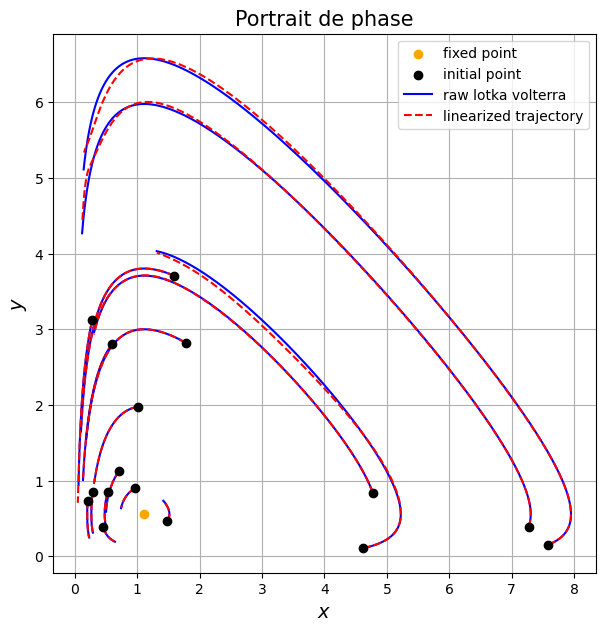

In [238]:
def forecast_linearized(x0, t_end):
    t = 0
    x = koopman(x0)
    x = poly.transform(np.array([x]))[0]
    xs = [x]
    while t < t_end:
        x = A_T.T @ x
        #x_sub = x[[1,2]]
        #x = poly.transform(np.array([x_sub]))[0]
        t += dt
        xs.append(x)
    
    xs = np.array(xs)
    return xs

plt.figure(figsize=(7,7))
plt.scatter(fix_pt[0],fix_pt[1],c='orange',zorder=3,label='fixed point')
t_end = 1000 * dt
plt.grid()

for i in range(16):
    yy = np.random.uniform(-2, 2, (2,))
    x0 = koopman_inv(yy)

    lv = LotkaVolterra(trend_parameters=trend_parameters,scheme_name=scheme)
    times, saved_times = lv.time_window(t_end, dt)

    traj = lv.forecast(x0, times, saved_times=saved_times)
    traj_X = np.log(np.array(list(traj.values()))) - np.log(fix_pt)
    traj_X = np.array(list(traj.values()))

    plt.scatter(traj_X[0, 0],traj_X[0, 1],c='k',zorder=3,label='initial point')
    plt.plot(traj_X[:,0], traj_X[:,1],label=f'raw lotka volterra', c='b')


    plt.title("Portrait de phase",fontsize=15)
    plt.xlabel(r"$x$", fontsize=14) ; plt.ylabel(r"$y$", fontsize=14);

    traj_lin = forecast_linearized(x0, t_end)
    traj_lin_sub = koopman_inv(traj_lin[:, [1,2]])
    plt.plot(traj_lin_sub[:,0], traj_lin_sub[:,1],label="linearized trajectory", c='r', linestyle='--');
    if i == 0:
        plt.legend();